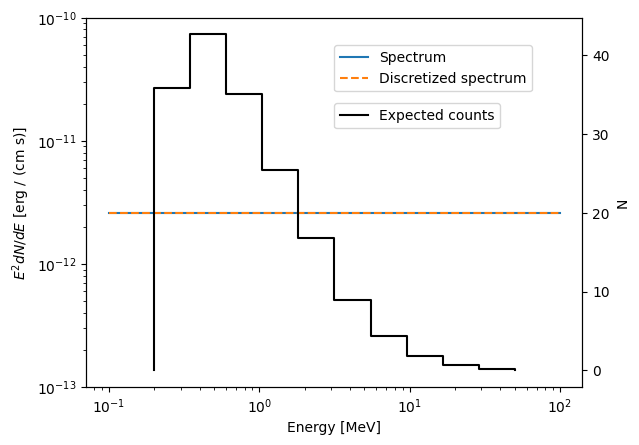

In [119]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from histpy import Histogram

duration = 1*u.day

index = -2 
flux_pivot = 1/u.erg/u.cm/u.s
pivot_energy = 1*u.MeV
source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = index, 
                                                min_energy = 100*u.keV,
                                                max_energy = 100*u.MeV),
                     flux_pivot = flux_pivot,
                     pivot_energy = pivot_energy)

response = SpectralResponse.open("spectral_response_onaxis_traddet.h5")

expected_signal_counts = response.expected_counts(source, duration)

fig,axl = plt.subplots()

source.plot_spectrum(axl, e2 = True, label = 'Spectrum');
source.plot_spectrum(axl, e2 = True, discretize_axis = response.photon_energy_axis, 
                     label = 'Discretized spectrum', ls = '--');
axl.legend(loc = (.5,.8))

axr = axl.twinx()
expected_signal_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7))

In [ ]:
Relation to nufnu. Energy decafe. Fermi acceleration

0-th order chi2 fit
Flux  =  1.40 +- 0.3 [1 / (cm erg s)]
Index = -2.08 +- 0.2


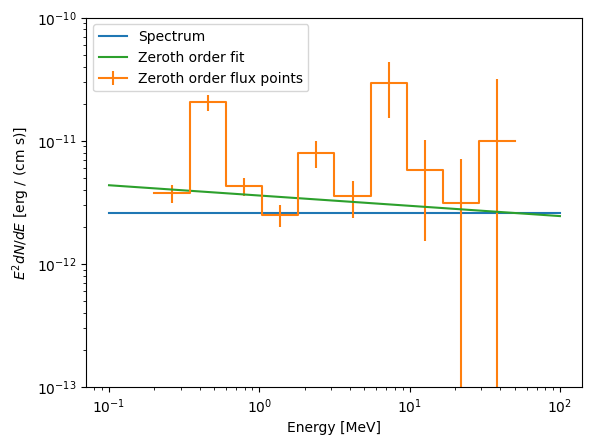

In [106]:
# 0-th order
fig,ax = plt.subplots()

source.plot_spectrum(ax, e2 = True, label = 'Spectrum');

approx_flux = Histogram(expected_signal_counts.axis, 
                        expected_signal_counts.contents,
                        sumw2 = expected_signal_counts.contents)# Start from observed counts
approx_flux /= duration # Per time
approx_flux /= response.effective_area().interp(expected_signal_counts.axis.centers) # Per area
approx_flux /= expected_signal_counts.axis.widths # Per energy
approx_flux = approx_flux.to(u.Unit(1/u.erg/u.cm/u.s), copy = True) # Match unit for plotting

(approx_flux * approx_flux.axis.centers.to(u.erg)**2).plot(ax, label = "Zeroth order flux points")

popt, pcov = approx_flux.fit(lambda energy,norm,index: norm*energy**index)
perr = np.sqrt(np.diag(pcov))
print("0-th order chi2 fit")
print(f"Flux  =  {popt[0]:.2f} +- {perr[0]:.1f} [{approx_flux.unit}]")
print(f"Index = {popt[1]:.2f} +- {perr[1]:.1f}")

source_fit = PointSource(offaxis_angle = 0*u.deg,
                         spectrum = PowerLawSpectrum(index = popt[1], 
                                                    min_energy = 100*u.keV,
                                                    max_energy = 100*u.MeV),
                         flux_pivot = popt[0]*approx_flux.unit,
                         pivot_energy = pivot_energy)
source_fit.plot_spectrum(ax, e2 = True, label = "Zeroth order fit")

ax.legend()

Em is not Ei. Would have worked if only diagonal. Can apply correction, but sts better and usually easier to forward folding. Explain unfolding.

(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x13872d210>)

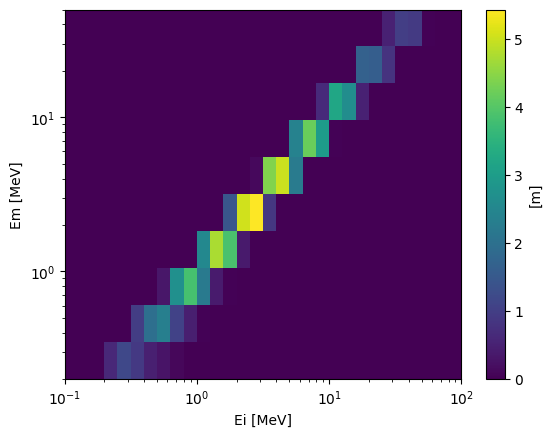

In [7]:
response.plot()

## Likelihood

Fit model directly to the data. No intermediate step with flux points.
Most likely model is the one the maximizes the probability of obtaining the observed data.
Explain why Poisson
Work with log. Getting rid of factorial. Simplify

In [128]:
%%time

from histpy import Axis
from copy import copy, deepcopy

data = deepcopy(expected_signal_counts)

# See exercise below
data[:] = np.random.poisson(data.contents)

log_like = Histogram([Axis(np.geomspace(.5,2,31)/u.erg/u.cm/u.s, label = 'flux', scale = 'log'),
                      Axis(np.linspace(-3,-1,31), label = 'index')])

for nflux, hyp_flux in enumerate(log_like.axes['flux'].centers):
    for nindex, hyp_index in enumerate(log_like.axes['index'].centers):

        print(f"At {nflux}/{log_like.axes['flux'].nbins} {nindex}/{log_like.axes['index'].nbins} ", end="\r")
        
        source_hyp = PointSource(offaxis_angle = 0*u.deg,
                                 spectrum = PowerLawSpectrum(index = hyp_index, 
                                                             min_energy = 100*u.keV,
                                                             max_energy = 100*u.MeV),
                                 flux_pivot = hyp_flux,
                                 pivot_energy = 1*u.MeV)

        expectation = response.expected_counts(source_hyp, duration)

        log_like[nflux, nindex] = np.sum(data.contents*np.log(expectation.contents) - expectation.contents)

CPU times: user 28.8 s, sys: 435 ms, total: 29.3 s
Wall time: 31.7 s


Wilk's theorem. Usually works, but be careful. If it doesn't you'll need to simulate the log_like distribution under 

Forward-folding maximum likelihood fit
Flux  = 1.07  +0.2 -0.1 [1 / (cm erg s)]
Index = -1.90 +0.2 -0.1


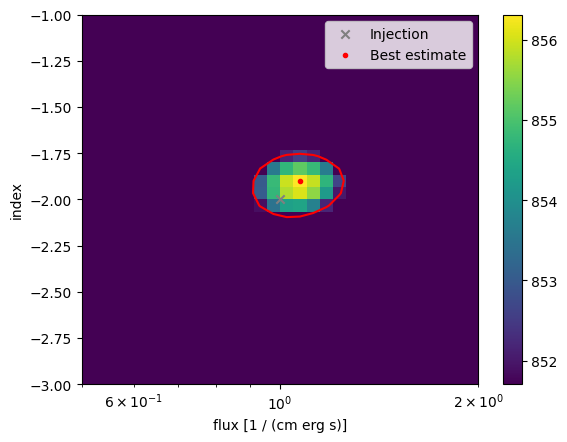

In [129]:
from scipy.stats import chi2

ts = 2*log_like

argmax_ts = np.unravel_index(np.argmax(ts), ts.nbins)
max_ts = ts[argmax_ts]

flux_opt = ts.axes[0].centers[argmax_ts[0]] 
index_opt = ts.axes[1].centers[argmax_ts[1]] 

uncertainty_containment = .9
unc_contour_ts = max_ts - chi2.ppf(uncertainty_containment, df = 2)

flux_upper_bound = np.max(ts.axes[0].upper_bounds[np.max(ts >= unc_contour_ts, axis = 1)])
flux_lower_bound = np.max(ts.axes[0].lower_bounds[np.max(ts >= unc_contour_ts, axis = 1)])
index_upper_bound = np.max(ts.axes[1].upper_bounds[np.max(ts >= unc_contour_ts, axis = 0)])
index_lower_bound = np.max(ts.axes[1].lower_bounds[np.max(ts >= unc_contour_ts, axis = 0)])

print("Forward-folding maximum likelihood fit")
print(f"Flux  = {flux_opt.value:.2f}  +{flux_upper_bound.value-flux_opt.value:.1f} {flux_opt.value-flux_lower_bound.value:.1f} [{flux_opt.unit}]")
print(f"Index = {index_opt:.2f} +{index_upper_bound-index_opt:.1f} {index_opt-index_lower_bound:.1f}")

fig,ax = plt.subplots()

ts.plot(ax, vmin =  unc_contour_ts)

ax.contour(ts.axes['flux'].centers,
           ts.axes['index'].centers,
           ts.contents.transpose(),
           levels = [unc_contour_ts],
           colors = 'red')

ax.scatter(flux_pivot, index, color = 'grey', marker = 'x', label = 'Injection')

ax.scatter(flux_opt, index_opt, color = 'red', marker = '.', label = 'Best estimate')

ax.legend()

Once likelyhood is computed, at bunch of possibilities ipen open up.
Sample like profile. coarser. Minuit/minimizer. Other methods, bayesian.
Complicated with multiple parameters.
Best from injection is grid artigract. You can increate it

Excersize: chang the pivot value. Arbitrary. Correlation

Excersize: poisson fluctuate. Check if true value is between the 90% contour 90% of the time

## Bkg and other nuisance parameters

Explain nuisance parameters

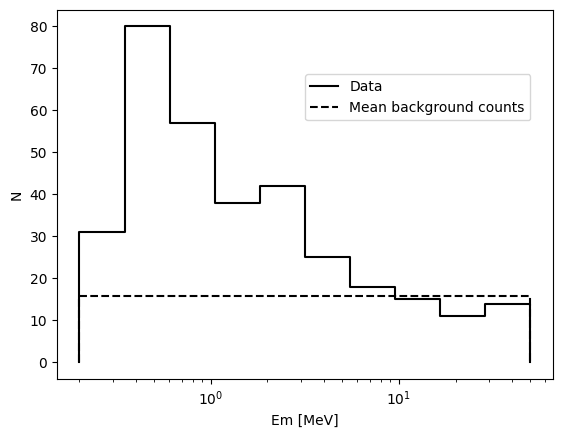

In [136]:
data = deepcopy(expected_signal_counts)

mean_bkg = Histogram(data.axis)
mean_bkg[:] = 1 # "Flat" bkg. Same in all Em bins
mean_bkg *= np.sum(data)/np.sum(mean_bkg) # Same bkg as signal counts

bkg = deepcopy(mean_bkg)
# See exercise below
data[:] = np.random.poisson(data.contents)
bkg[:] = np.random.poisson(bkg.contents)

fig,ax = plt.subplots()

(bkg+data).plot(ax, color = 'black', label = 'Data')
mean_bkg.plot(ax, color = 'black', label = 'Mean background counts', ls = '--')
ax.set_ylabel("N")
ax.legend(loc = (.5,.7))

Excersize: Maximum in bkg for each grid point. look at the errors. Multiple components
- Null hypothesis flux = 0. bakg only. Get the the detection significance

In [ ]:
log_like = Histogram([Axis(np.geomspace(.5,2,31)/u.erg/u.cm/u.s, label = 'flux', scale = 'log'),
                      Axis(np.linspace(-3,-1,31), label = 'index'),
                      Axis(np.linspace(0,10,31), label = 'bkg_norm')])


expectation = response.expected_counts(source_hyp, duration) + bkg_norm * mean_bkg